<a href="https://colab.research.google.com/github/iamemc/PD_02/blob/flip/PD03_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining / Prospecção de Dados

## Diogo F. Soares and Sara C. Madeira, 2020/21

# Project 2 - Clustering

## Logistics 

**_Read Carefully_**

**Students should work in teams of 2 or 3 people**. 

Individual projects might be allowed (with valid justification), but will not have better grades for this reason. 

The quality of the project will dictate its grade, not the number of people working.

**The project's solution should be uploaded in Moodle before the end of `April, 18th (23:59)`.** 

Students should **upload a `.zip` file** containing all the files necessary for project evaluation. 
Groups should be registered in [Moodle](https://moodle.ciencias.ulisboa.pt/mod/groupselect/view.php?id=139096) and the zip file should be identified as `PDnn.zip` where `nn` is the number of your group.

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. You can use `PD_202021_P2.ipynb`as template. In your `.zip` folder you should also include an HTML version of your notebook with all the outputs** (File > Download as > HTML).

**Decisions should be justified and results should be critically discussed.** 

_Project solutions containing only code and outputs without discussions will achieve a maximum grade 10 out of 20._

## Dataset and Tools

In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and **[Scikit-learn](http://scikit-learn.org/stable/)**.

The dataset to be analysed is **`medulloblastoma_genes.csv`**. It includes 76 samples of medulloblastoma (MB) with respective expression levels of 54.675 genes measured in children with ages between 3 and 16 years. Medulloblastoma is a malignant childhood brain tumour comprising four discrete subgroups. 

In this project you will consider the labels of the samples included in the `labels.csv` file where samples are labelled as MB-CL or Other. In this case, we have 51 samples of classic medulloblastoma (MB-CL) and 25 other types (namely: 6 desmoplastic nodular, 17 anaplastic and 2 medullomyoblastoma).

In `medulloblastoma_genes.csv` each line represents a sample and each column represents a gene.


**The goal is to cluster samples and (ideally) find "MB-CL" groups and "Other MB" groups.** 

## Team Identification

**GROUP PD03**

Students:

* **Eduardo Carvalho - nº55881**
* **Filipe Santos - nº55142**
* **Ivo Oliveira - nº50301**

## 1. Load and Preprocess Dataset

At the end of this step you should have:
* a 76 rows × 54675 columns matrix, **X**, containing the values of the 54675 features for each of the 76 samples.
* a vector, **y**, with the 76 type of medulloblastoma, which you can use later to evaluate clustering quality.

### Importing relevant libraries

In [281]:
from pandas import read_csv, DataFrame, Series
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sn
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score, silhouette_samples
from sklearn.metrics.cluster import contingency_matrix

### Importing the datasets

In [282]:
X=read_csv('/content/medulloblastoma_genes.csv', index_col=0)
X.shape

(76, 54675)

In [283]:
X.head(3)

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,1438_at,1487_at,1494_f_at,1552256_a_at,1552257_a_at,1552258_at,1552261_at,1552263_at,1552264_a_at,1552266_at,1552269_at,1552271_at,1552272_a_at,1552274_at,1552275_s_at,1552276_a_at,1552277_a_at,1552278_a_at,1552279_a_at,1552280_at,1552281_at,1552283_s_at,1552286_at,1552287_s_at,1552288_at,1552289_a_at,1552291_at,1552293_at,1552295_a_at,1552296_at,...,AFFX-HUMRGE/M10098_3_at,AFFX-HUMRGE/M10098_5_at,AFFX-HUMRGE/M10098_M_at,AFFX-hum_alu_at,AFFX-LysX-3_at,AFFX-LysX-5_at,AFFX-LysX-M_at,AFFX-M27830_3_at,AFFX-M27830_5_at,AFFX-M27830_M_at,AFFX-PheX-3_at,AFFX-PheX-5_at,AFFX-PheX-M_at,AFFX-r2-Bs-dap-3_at,AFFX-r2-Bs-dap-5_at,AFFX-r2-Bs-dap-M_at,AFFX-r2-Bs-lys-3_at,AFFX-r2-Bs-lys-5_at,AFFX-r2-Bs-lys-M_at,AFFX-r2-Bs-phe-3_at,AFFX-r2-Bs-phe-5_at,AFFX-r2-Bs-phe-M_at,AFFX-r2-Bs-thr-3_s_at,AFFX-r2-Bs-thr-5_s_at,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
GSM918578,7.59594,6.14440,4.82431,5.67092,4.14155,5.48935,6.01078,5.17671,4.83708,4.77996,3.42752,6.03596,5.21494,6.03596,6.31192,4.79744,4.88884,4.92362,5.93357,3.41773,3.61899,3.40784,3.79099,7.13106,6.52605,4.49647,6.31771,4.52070,6.31861,4.29729,4.14946,5.07455,5.00395,6.86808,3.36730,4.35799,6.42487,3.66612,5.80724,4.30946,...,7.36941,9.31655,8.55281,11.6420,6.67064,5.54635,5.82718,5.13521,8.45163,8.64319,5.99121,6.00857,6.30792,8.43453,8.10077,8.17662,5.93410,5.98444,5.68256,6.71901,6.84215,6.21441,7.29227,6.87863,6.85667,7.72991,7.93229,7.97543,8.78430,8.64773,10.2364,10.1202,11.5560,11.2308,6.94803,6.42487,6.70991,4.48639,4.43082,3.48738
GSM918579,7.80665,6.19154,5.24439,5.62149,3.41773,5.70478,5.98896,3.45316,4.34121,4.28772,3.65066,6.71732,5.21927,5.81622,6.86537,5.44760,5.02913,5.03565,5.32885,4.34251,3.60550,4.55913,5.23750,6.03644,3.62966,4.99991,6.06773,5.29782,5.81532,3.62434,5.00193,4.88280,5.86391,7.56034,4.58701,5.15560,6.29397,3.54385,5.58837,4.51634,...,8.40349,8.21690,8.62825,11.6876,6.40506,3.24259,4.51415,3.77735,8.79546,7.61923,5.42539,4.08598,4.08598,7.78589,3.19048,6.33204,5.52744,4.12552,4.93807,6.28320,4.14946,4.70139,6.25652,4.37952,4.70048,7.83257,8.51571,8.16721,9.16005,9.14255,10.4747,10.4893,11.6799,11.3475,6.09785,4.38328,4.68583,3.40120,4.20916,4.40915
GSM918580,7.60080,5.97406,5.36270,5.78598,3.32863,6.13340,6.09108,3.63495,5.12218,4.75875,3.62167,5.83247,5.27556,6.73875,6.84800,4.83071,5.34949,5.14458,5.01263,5.17445,3.18635,3.72569,5.51302,5.25489,5.40268,4.08598,6.13144,5.73722,6.00241,3.79773,5.59211,6.16395,6.77992,7.13130,4.17746,5.51826,6.96414,4.63376,6.01567,4.63861,...,8.51057,8.08024,8.62006,11.8940,6.83604,4.67470,4.92362,3.72328,10.25130,8.65130,5.88444,3.37074,4.16044,8.09071,3.19048,6.20799,5.65073,4.84261,4.87137,6.00018,4.72739,3.58074,6.83098,4.20767,4.80484,8.25546,8.92078,8.39658,9.45981,9.42748,10.8532,10.7125,11.9298,11.6038,6.49375,3.24259,3.91999,3.13114,4.02892,4.93087


> X is a dataset with 76 rows and close to 54675 (!) features.
>
> Sample numbers are the dataset's index and the genes its features.
>
> At first glance, its values seem to be in the same range (between 0 and 10), which might indicate there are big differences in scale. We will, however, scale the dataset in a future step to prevent scaling issues.

In [284]:
y=read_csv('/content/labels.csv', index_col=0)
y.shape

(76, 1)

In [285]:
y.head(3)

,class
samples,
GSM918578,MB-CL
GSM918579,MB-CL
GSM918580,MB-CL


In [286]:
y['class'].value_counts()

MB-CL    51
Other    25
Name: class, dtype: int64

> y is a dataset with 76 rows and a single column.
>
> Like X, the samples are the rows and the column represents the true class to which each sample belongs.
>
> We can also confirm that there are only 2 classes in the dataset - 'MB-CL' and 'Other' - with a proportion of 2:1 in favor of the class 'MB-CL'.

## 2. Dimensionality Reduction

As you already noticed the number of features (genes) is extremely high when compared to the number of objects to cluster (samples). In this context, you should perform dimensionality reduction, that is, reduce the number of features, in two ways:

* [**Removing features with low variance**](http://scikit-learn.org/stable/modules/feature_selection.html)

* [**Using Principal Component Analysis**](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

At the end of this step you should have two new matrices with the same number of rows, each with a different number of columns (features): **X_variance** and **X_PCA**. 

**Don't change X you will need it!**

### Removing features with low variance

> We will start by using VarianceThreshold with threshold=0. This creates an array with the variance values for every one of the 54675 features of the dataset.
>
> We will also standardize the dataset using MinMaxScaler to reduce the impact of the scale of the data in the variance. It is interesting to note that using StandardScaler instead would convert all the variances in the dataset to 1 and destroy the utility of the variance values for dimensionality reduction.

In [287]:
# creating a VarianceThreshold object with threshold=0
var_thresh = VarianceThreshold(threshold=0)

# standardizing the data
std_X = MinMaxScaler().fit_transform(X)

# fitting the object to the standardized dataset
var_thresh.fit(std_X)

# creating a dataframe containing the variances for all the features in the dataset
df_var=DataFrame(var_thresh.variances_, columns=['Variance'])\
                .sort_values(by='Variance', ascending=False)
df_var.head()

,Variance
4657,0.135650
14447,0.134134
33847,0.128592
16070,0.125255
40664,0.123512


> The variance values are already ordered from highest to lowest. We can see that the highest 5 values range from 0.1356 to 0.1235.
> We will now plot all of these values to better understand how the variance varies across the standardized dataset.

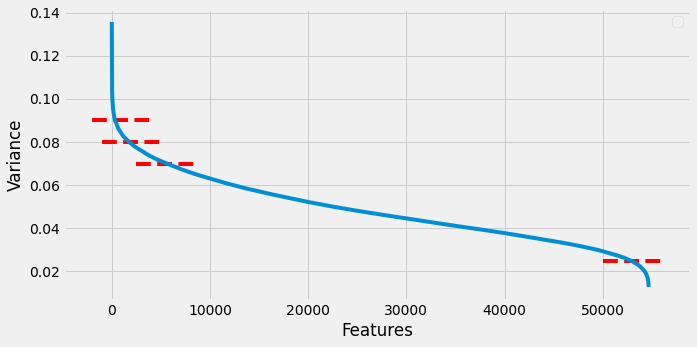

In [288]:
# plotting the variances in df_var
# we need to reset the index for the plot to make sense
plt.figure(figsize=(10, 5))
plt.plot(df_var.reset_index(drop=True))
plt.hlines(0.09, -2000, 4000, colors='red', linestyles='--')
plt.hlines(0.08, -1000, 5000, colors='red', linestyles='--')
plt.hlines(0.07, 2500, 8500, colors='red', linestyles='--')
plt.hlines(0.025, 50000, 56000, colors='red', linestyles='--')
plt.grid(True)
plt.xlabel('Features')
plt.ylabel('Variance');
plt.legend('')
plt.show()

> We can see the variance for most of the features is smaller than 0.06. 
>
> We can also identify variance=0.08 as the point where the values start to stabilize.
>
> For this reason, we will keep all features that have variance higher than 0.09. Doing this will be a considerable drop in the number of features. 
>
> We could have opted for a lower value as the threshold, like 0.8 or 0.7, as they also belong to the region where the variance starts to stabilize for the first time.
>
> We could also choose an even lower value, like 0.025, for which there is another stabilization in the variance values. However, this would still leaves us with over 50 thousand features.
>
> So, we will create a new VarianceThreshold object with threshold=0.09, fit it to the standardized dataset and see how many features we are left with.

In [289]:
# creating a new VarianceThreshold object with threshold=1
vt = VarianceThreshold(threshold=0.09)

# fitting the dataset
vt.fit(std_X)

# get_support is an array with True/False values
# True values identify features with variance > 1
mask = vt.get_support()

# we can use mask to subset the original dataset and create X_variance
# X_variance contains only features with variance > 1
X_variance = X.loc[:, mask]

# checking the difference in feature number between X and X_variance
print('Features in X:', X.shape[1])
print('Features in X_variance:', X_variance.shape[1])
print('Difference in number of features:', X.shape[1]-X_variance.shape[1])

Features in X: 54675
Features in X_variance: 349
Difference in number of features: 54326


> By defining the cut-off point for variance as 0.09 we were able to reduce the number of features in the dataset from 54675 to 349.
>
> This means we eliminated 54326 features that had low variance and, as such, were not good enough to differentiate the genes between the two classes in study.

### Using Principal Components Analysis

> Before applying PCA to the dataset we need to standardize its values. This time we use StandardScaler as we want to negate the impact of high-variance features in PCA.

In [290]:
# Standardizing the features
std_X_2 = StandardScaler().fit_transform(X)

> To define the number of components to be used we will follow the same process we employed to X_variance.
>
> We will start with a PCA object with n_components=None that includes all of the components for the dataset and use it to figure out the ideal number of components.

In [291]:
# creating a PCA object with n_components=None
pca = PCA()

# fitting PCA to the standardized dataset
pca.fit(std_X_2)

# checking the total number of components
pca.n_components_

76

> We can see that, after applying PCA to the standardized dataset, we were left with 76 components.
>
> We can further reduce this number by selecting only the components that explain a high percentage of the total variance of the dataset.
>
> For that reason, we will plot the cumulative sum of the explained variance of pca, after fitting std_X_2.

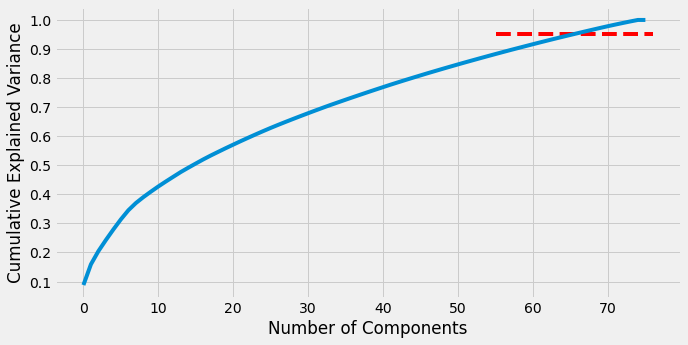

In [292]:
# creating a plot for the cumulative sum of explained variance in std_X
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.yticks(np.linspace(0.1, 1, 10))
plt.hlines(y=0.95, xmin=55, xmax=76, colors='red', linestyles='--')
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

> In this graph we see the cumulative sum of explained variance for all components. The components are ordered by decreasing value of explained variance and has a max value of 1 (the total variance in the dataset).
>
> We can choose a value of explained variance that we think is "good enough" to represent the total dataset and identify the number of components that we need to keep to achieve it.
>
> For example, if we defined the threshold as 70% (0.7) we can see that we would need to keep at least 35 components.
>
> Most of the components have similar explained variance values as evidenced by the lack of a pronounced curve in the plot. The only curve we can identify is between 5 and 10 components. However, this number of components only accounts for about 35% of all variance, a very low number.
>
> In this case, we will define the threshold as 95%, as this is allows for a high value of explained variance while reducing some of the less important components. 
>
> We can see that 0.95 is reached between 60 and 70, which means we will be left with a high number of components. However, this also means we can cut close to 10 components from the total number.
>
> We will again apply PCA to the standardized dataset but, this time, we will define the number of components as the percentage of explained variance that we defined before (0.95).

In [293]:
# creating a PCA object with only the components needed to achieve 95% explained variance
pca = PCA(n_components=0.95)

# fitting the object to the standardized dataset
pca.fit(std_X_2)

# creating a new dataframe X_PCA that contains the number of components needed to meet the threshold
X_PCA = pca.transform(std_X_2)

# checking the difference in number of features in X and X_PCA
print('Features in X:', X.shape[1])
print('Features in X_PCA:', len(X_PCA[0]))
print('Difference in number of features:', X.shape[1]-len(X_PCA[0]))

Features in X: 54675
Features in X_PCA: 67
Difference in number of features: 54608


> After PCA, we are now left with an object with (only) 67 features, a much smaller number of features than the 54675 in the original dataset, representing a decrease in more than 54 thousand features.

> After all of this preprocessing, we end up with 3 different datasets: X, X_variance and X_PCA. We also have all the true labels for the samples in the dataset y.

In [294]:
print('X has', X.shape[0], 'rows and', X.shape[1], 'features.')
print('X_variance has', X_variance.shape[0], 'rows and', X_variance.shape[1], 'features.')
print('X_PCA has', X_PCA.shape[0], 'rows and', X_PCA.shape[1], 'features.')
print('y has', y.shape[0], 'rows and', y['class'].nunique(), 'different labels.')

X has 76 rows and 54675 features.
X_variance has 76 rows and 349 features.
X_PCA has 76 rows and 67 features.
y has 76 rows and 2 different labels.


## 3. Clustering Samples using Partitional Clustering

Use **`K`-means** to cluster the samples:

* Cluster the original data (54.675 features): **X**.
    * Use different values of `K`.
    * For each value of `K` present the clustering by specifying how many samples MB-CL and Other are in each cluster.     
    For instance, `{0: {'MB-CL': 51, 'Other': 0}, 1: {'MB-CL': 0, 'Other': 25}}` is the ideal clustering that we aimed at obtained with K-means when `K=2`, where the first cluster has 51 MB-CL samples and 0 Other samples and the second cluster has 0 MB-CL samples and 25 Other samples.
    You can choose how to output this information.  **Tip**: You can explore the usage of contigency matrices.
    * What is the best value of `K` ? Justify using the clustering results and the [Silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

* Cluster the data obtained after removing features with low variance: **X_variance**.
    * Study different values of `K` as above.

* Cluster the data obtained after applying PCA: **X_PCA**.
    * Study different values of `K` as above.

* Compare the results obtained in the three datasets above for the best `K`. 
* Discuss the results.

## K-Means - X

> We will start by running K-Means on the original dataset with all 54675 features. This will provide a baseline to which we can compare the results from X_variance and X_PCA.

### Running k-means for different values of k

> By K-Means for values of k between 2 and 10 we are able to see how this variation impacts the distribution of samples between clusters.
>
> We will also create contingency matrices to compare the clustering results with the true labels and evaluate how good the performance of K-Means is. 
>
> Ideally, we want the clusters to contain only samples from one of the two classes of medulloblastoma.

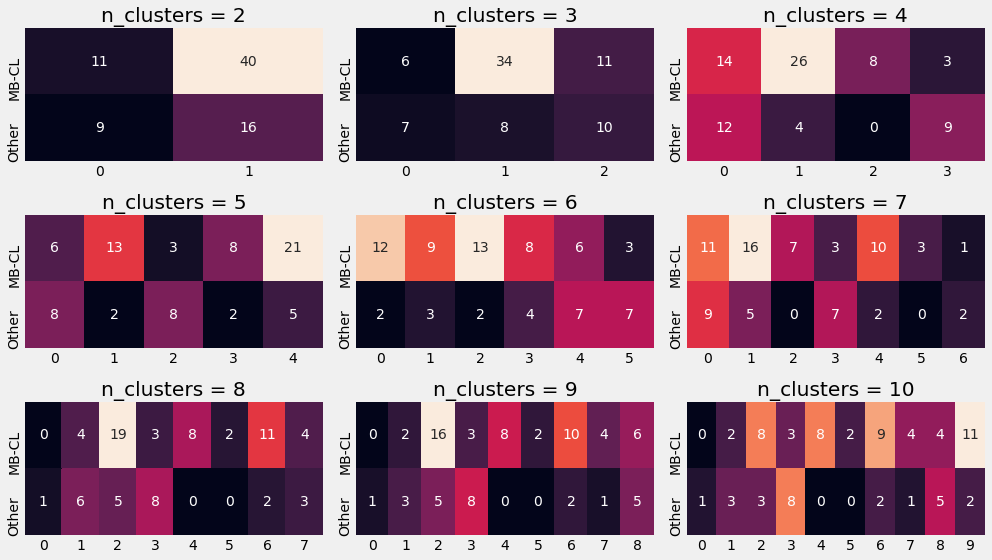

In [295]:
# defining rows and cols for the plot grid
rows=3
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(14,8))

# starting at k=2 and going until k=10
k=2
while k < 11:
  for i in range(rows):
    for j in range(cols):
      # creating a KMeans object with n_clusters=k
      kmeans = KMeans(n_clusters=k, random_state=0)
      # fitting the object to the data
      kmeans = kmeans.fit(X)
      # creating a contingency matrix with true labels and kmeans labels
      cm_X=contingency_matrix(y['class'], kmeans.labels_)
      sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> The contingency matrices show how many samples from which class are in each cluster. For example, when k=2, we have 11 samples of class 'MB-CL' and 9 samples of class 'Other' in cluster 0 and 40 samples of class 'MB-CL' and 16 of class 'Other' in cluster 1.
>
> We can already see that there is no k value for which we have the ideal scenario of having the classes perfectly separated.
>
> The majority of the clusters appear to be predominantly composed of class 'MB-CL' which might be related to the proportion of the classes in the dataset (the number of samples with class 'MB-CL' is double the number of samples from class 'Other').
>
> The first cluster which is composed only of samples from class 'MB-CL' appears when k=4. The first cluster which is composed only of samples from class 'Other' appears when k=8.
>
> While the contingency matrices are a good way to visualize the samples' separation in clusters we need a hard metric that can indicate how well that separation is being done. For that reason, we can resort to the Silhouette score.

### Determining ideal number of clusters by Silhouette Score

> We can use the silhouette score to evaluate the quality of the clusters created after aplying K-Means in terms of how well samples are clustered with other samples that are similar to each other. 
>
> This score varies between -1 and 1.  A score of 1 that the cluster is dense and well-separated than other clusters. A value close to 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters. A negative score indicates that the samples might have got assigned to the wrong clusters.
>
> By using silhouette_score we obtain the average Silhouette score for a certain k.
>
> We will calculate this value for n_clusters between 2 and 10, storing the values in a list and plotting them, for an easier analysis.

for n_clusters = 2 the silhouette score is 0.103.
for n_clusters = 3 the silhouette score is 0.079.
for n_clusters = 4 the silhouette score is 0.085.
for n_clusters = 5 the silhouette score is 0.079.
for n_clusters = 6 the silhouette score is 0.054.
for n_clusters = 7 the silhouette score is 0.076.
for n_clusters = 8 the silhouette score is 0.073.
for n_clusters = 9 the silhouette score is 0.072.
for n_clusters = 10 the silhouette score is 0.059.




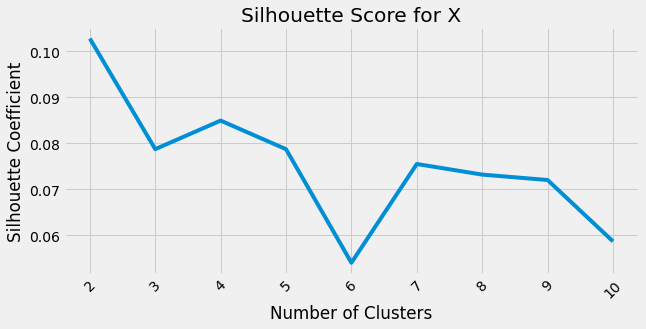

In [324]:
# list to store all silhouette scores
silhouette_coefficients = []

# loop to calculate silhouette scores between 2 and 10
for i in range(2, 11):
  # creating a KMeans object with varying n_clusters parameter
  kmeans = KMeans(n_clusters=i, random_state=0)
  # fitting the data to the original dataset
  kmeans.fit(X)
  # calculating the silhouette score 
  score = silhouette_score(X, kmeans.labels_)
  # storing the value
  silhouette_coefficients.append(score)
  # printing the value calculated
  print('for n_clusters =', i, 'the silhouette score is', str(round(score, 3)) + '.')

print('\n')

# plotting silhouette_coefficients, a list with all silhouette scores calculated
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.title('Silhouette Score for X')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.tight_layout()
plt.gcf().set_size_inches(10, 5)
plt.xticks(rotation = 45)
plt.show()

> Looking at the plot obtained we can see that there is a decreasing trend as the value for n_clusters increases.
>
> There are only 2 increases in score, for n_clusters=4 and n_clusters=7.
>
> As we have seen before, the best value for the silhouette score is the one that is closest to 1. With that in mind, the best number of clusters is 2 - where the average silhouette score is the highest (0.103).
>
> However, as we saw before, the samples are not correctly separated between clusters. And, despite being the highest value, the silhouette score is also very close to 0, which means it is actually not a good result.
>
> Now that we know the average i

In [332]:
# defining silhouette plot function from TP08
def draw_silhouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    for i,c in enumerate(clusters):
        silhouette_values = silhouette_samples(X, labels)
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters) #np.array(["r", "g", "b", "k", "y"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    plt.show()

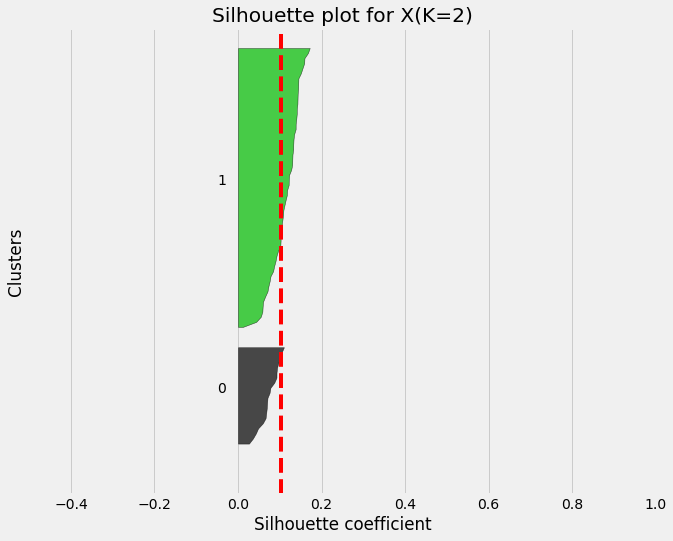

In [333]:
# Final kmeans for X and contingency matrix
kmeans_X = KMeans(n_clusters=2, random_state=0)
kmeans_X = kmeans_X.fit(X) 

# draw silhouette plot
draw_silhouette(X, kmeans_X.labels_, "for X(K=2)")

for n_clusters = 2 the silhouette score is 0.103.



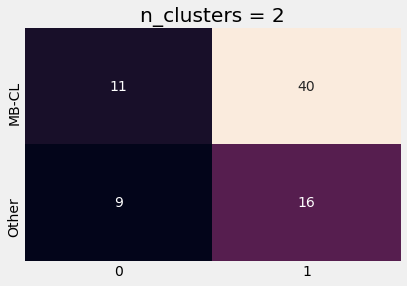

In [297]:
# Final kmeans for X and contingency matrix
kmeans_X = KMeans(n_clusters=2, random_state=0)
kmeans_X = kmeans_X.fit(X) 

# silhouette score for X, n_clusters=2
score_X = silhouette_score(X, kmeans_X.labels_)
print('for n_clusters = 2 the silhouette score is', str(round(score_X, 3)) + '.\n')

# contingency matrix for X, n_clusters=2
cm_X=contingency_matrix(y['class'], kmeans_X.labels_)
sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.title('n_clusters = 2')
plt.show()

## K-means - X_variance

> For the dataset with only high-variance features we will adopt the same process as before and start by plotting the contingency matrices from k=2 to k=10.

### Running k-means for different values of k

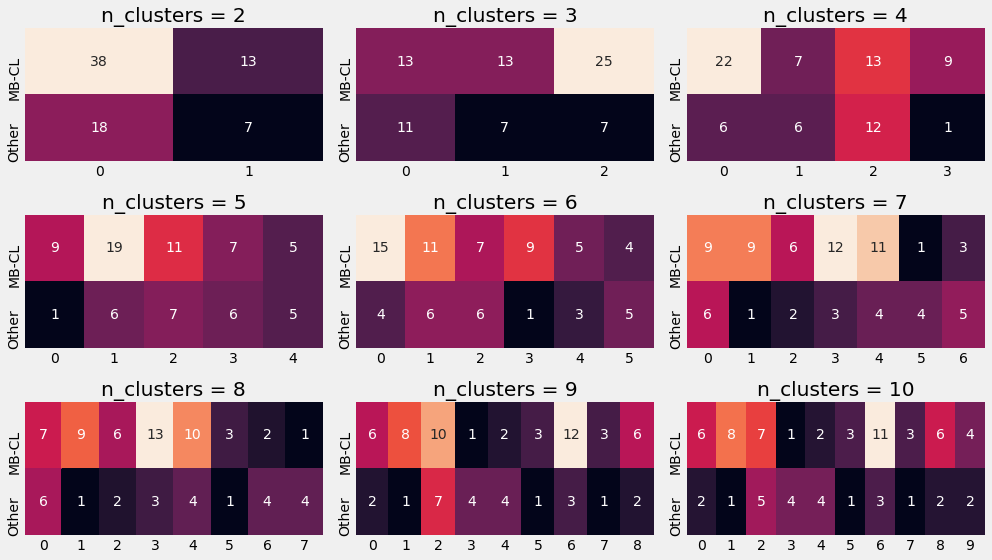

In [298]:
# defining rows and cols for the plot grid
rows=3
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(14,8))

# starting at k=2 and going until k=10
k=2
while k < 11:
  for i in range(rows):
    for j in range(cols):
      # creating a KMeans object with n_clusters=k
      kmeans = KMeans(n_clusters=k, random_state=0)
      # fitting the object to the data
      kmeans = kmeans.fit(X_variance)
      # creating a contingency matrix with true labels and kmeans labels
      cm_X_var=contingency_matrix(y['class'], kmeans.labels_)
      sn.heatmap(cm_X_var, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Like we saw in the matrices for X, there is no k value for which we have the ideal scenario of having the classes perfectly separated, when we use the high-variance dataset.
>
> The majority of the clusters appear to be predominantly composed of class 'MB-CL', as we have seen before.
>
> Unlike the previous case, there are no cluster comprised entirely of samples from the same class. The cluster with the biggest difference in classes appears when k=4 (cluster 3). The first predominantly 'Other' cluster appear when k=6.
>
> Like we did before, we will calculate the silhouette scores for each k value, to identify the case when the clusters are better separated.

### Determining ideal number of clusters by Silhouette Score

for n_clusters = 2 the silhoette score is 0.197
for n_clusters = 3 the silhoette score is 0.138
for n_clusters = 4 the silhoette score is 0.142
for n_clusters = 5 the silhoette score is 0.139
for n_clusters = 6 the silhoette score is 0.113
for n_clusters = 7 the silhoette score is 0.098
for n_clusters = 8 the silhoette score is 0.096
for n_clusters = 9 the silhoette score is 0.081
for n_clusters = 10 the silhoette score is 0.083




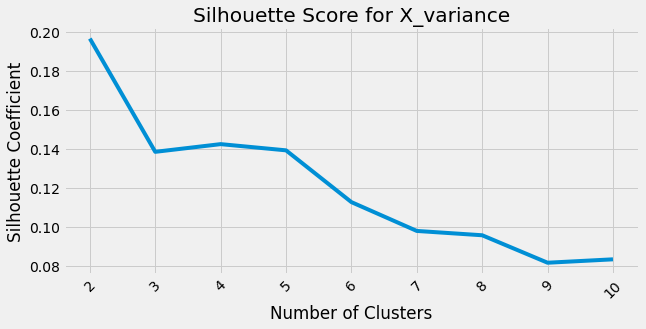

In [299]:
# list to store all silhouette scores
silhouette_coefficients = []

# loop to calculate silhouette scores between 2 and 10
for i in range(2, 11):
  # creating a KMeans object with varying n_clusters parameter
  kmeans = KMeans(n_clusters=i, random_state=0)
  # fitting the data to the dataset with only high-variance features
  kmeans.fit(X_variance)
  # calculating the silhouette score 
  score = silhouette_score(X_variance, kmeans.labels_)
  # storing the value
  silhouette_coefficients.append(score)
  # printing the value calculated
  print('for n_clusters =', i, 'the silhoette score is', round(score, 3))

print('\n')

# plotting silhouette_coefficients, a list with all silhouette scores calculated
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.title('Silhouette Score for X_variance')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.tight_layout()
plt.gcf().set_size_inches(10, 5)
plt.xticks(rotation = 45)
plt.show()

> As we saw in the previous case, the plot shows a decreasing trend in the silhouette score as the number of clusters increases.
> 
> There are, however, 3 small increases in the score (n_clusters = 4, 9 and 10).
>
> Like in the previous case, the silhouette score is highest when n_clusters = 2, with a value of 0.197. 
>
> Despite being almost double the value of the silhouette score for X and n_clusters=2, this is still a very low value meaning that the clusters are not very well separated from each other.

> Based on the silhouette score and the contingency matrices, we conclude that, for the dataset with only high-variance features, the ideal number of clusters is 2 - the silhouette score is the highest and there is some separation between labels.

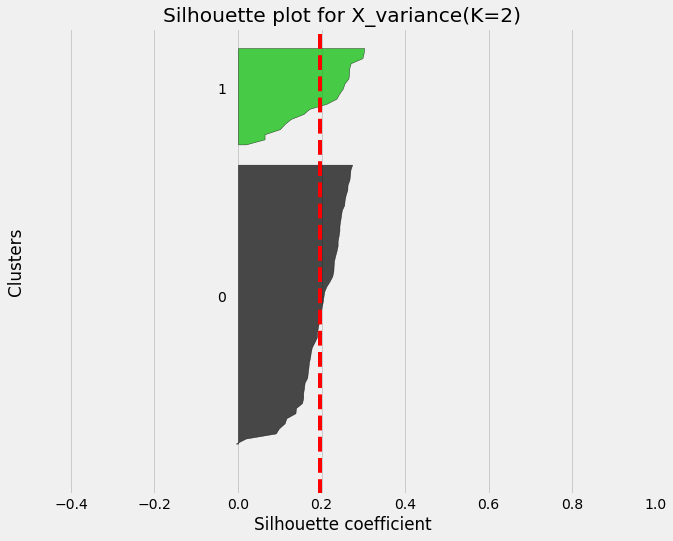

In [334]:
# Final kmeans for X_variance
kmeans_var = KMeans(n_clusters=2, random_state=0)
kmeans_var = kmeans_var.fit(X_variance) 

# draw silhouette plot
draw_silhouette(X_variance, kmeans_var.labels_, "for X_variance(K=2)")

for n_clusters = 2 the silhouette score is 0.197.



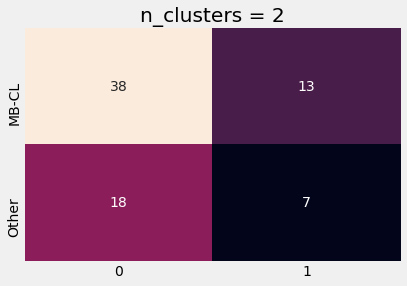

In [316]:
# Final kmeans for X_variance
kmeans_var = KMeans(n_clusters=2, random_state=0)
kmeans_var = kmeans_var.fit(X_variance) 

# silhouette score for X_variance, n_clusters=2
score_var = silhouette_score(X_variance, kmeans_var.labels_)
print('for n_clusters = 2 the silhouette score is', str(round(score_var, 3)) + '.\n')

# contingency matrix for X_variance, n_clusters=2
cm_var=contingency_matrix(y['class'], kmeans_var.labels_)
sn.heatmap(cm_var, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.title('n_clusters = 2')
plt.show()

## K-means - X_PCA

> Again, we will start by applying K-Means to the dataset after applying PCA, with k values ranging from 2 to 10.

### Running k-means for different values of k

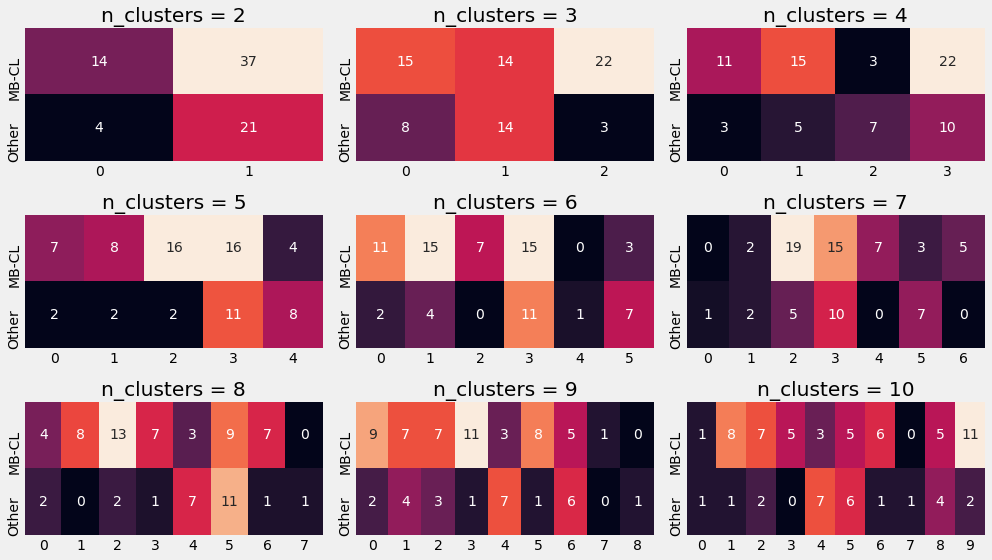

In [301]:
# defining rows and cols for the plot grid
rows=3
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(14,8))

# starting at k=2 and going until k=10
k=2
while k < 11:
  for i in range(rows):
    for j in range(cols):
      # creating a KMeans object with n_clusters=k
      kmeans = KMeans(n_clusters=k, random_state=0)
      # fitting the object to the data
      kmeans = kmeans.fit(X_PCA)
      # creating a contingency matrix with true labels and kmeans labels
      cm_X_PCA=contingency_matrix(y['class'], kmeans.labels_)
      sn.heatmap(cm_X_PCA, annot=True, cmap="rocket", cbar=False,
                yticklabels=['MB-CL','Other'], ax=axes[i,j])
      axes[i,j].set_title('n_clusters = ' + str(k))
      k+=1

fig.tight_layout()
plt.show()

> Like we saw in the matrices for X, there is no k value for which we have the ideal scenario of having the classes perfectly separated, when we use the high-variance dataset.
>
> The majority of the clusters appear to be predominantly composed of class 'MB-CL', as we have seen before. However, in this case, the first predominantly 'Other' cluster appears when k=4 (cluster 2), earlier than in previous steps.
>
> There are also clusters where all the samples belong to the same class. When k=6, cluster 2 has only 'MB-CL' samples while cluster 4 is composed of a single sample from class 'Other'.
>
> We will, again, calculate the silhouette scores for each k value to identify the best k and to be able to compare this clustering to the others presented before.

### Determining ideal number of clusters by Silhouette Score

for n_clusters = 2 the silhouette score is 0.089
for n_clusters = 3 the silhouette score is 0.034
for n_clusters = 4 the silhouette score is 0.035
for n_clusters = 5 the silhouette score is 0.036
for n_clusters = 6 the silhouette score is 0.045
for n_clusters = 7 the silhouette score is 0.049
for n_clusters = 8 the silhouette score is 0.033
for n_clusters = 9 the silhouette score is 0.017
for n_clusters = 10 the silhouette score is 0.021




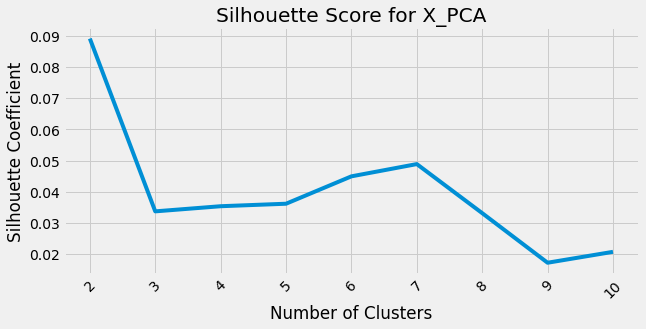

In [302]:
# list to store all silhouette scores
silhouette_coefficients = []

# loop to calculate silhouette scores between 2 and 10
for i in range(2, 11):
  # creating a KMeans object with varying n_clusters parameter
  kmeans = KMeans(n_clusters=i, random_state=0)
  # fitting the data to the dataset after applying PCA and 95% explained variance
  kmeans.fit(X_PCA)
  # calculating the silhouette score 
  score = silhouette_score(X_PCA, kmeans.labels_)
  # storing the value
  silhouette_coefficients.append(score)
  # printing the value calculated
  print('for n_clusters =', i, 'the silhouette score is', round(score, 3))

print('\n')

# plotting silhouette_coefficients, a list with all silhouette scores calculated
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.title('Silhouette Score for X_PCA')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.tight_layout()
plt.gcf().set_size_inches(10, 5)
plt.xticks(rotation = 45)
plt.show()

> Once again we see a decrease in silhouette score with the increase of n_clusters.
>
> There are, however, 5 increases in score (n_clusters = 4, 5, 6, 7 and 10).
>
>
> The highest silhouette score is, once again, for n_clusters=2, with a value of 0.089. This is very close to 0 and, as we have seen before, it means that the clusters are not well separated from each other.

> Based on the silhouette score we conclude that, for the dataset after standardization and PCA, the ideal number of clusters is 2, the value for which the silhouette score is the highest.

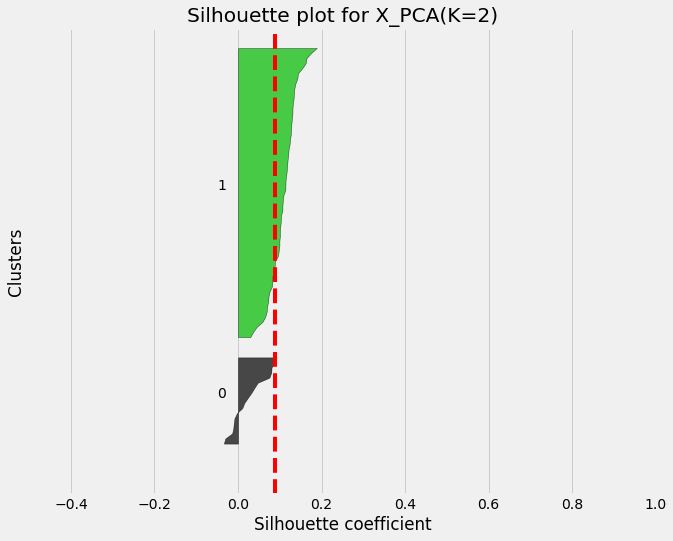

In [335]:
# Final kmeans for X_PCA
kmeans_PCA = KMeans(n_clusters=2, random_state=0)
kmeans_PCA = kmeans_PCA.fit(X_PCA) 

# draw silhouette plot
draw_silhouette(X_PCA, kmeans_PCA.labels_, "for X_PCA(K=2)")

for n_clusters = 2 the silhouette score is 0.089.



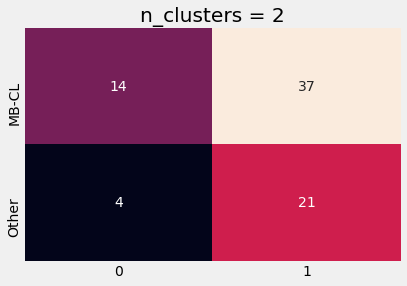

In [303]:
# silhouette score for X_PCA, n_clusters=2
score_PCA = silhouette_score(X_PCA, kmeans_PCA.labels_)
print('for n_clusters = 2 the silhouette score is', str(round(score_PCA, 3)) + '.\n')

# contingency matrix for X_PCA, n_clusters=2
cm_PCA=contingency_matrix(y['class'], kmeans_PCA.labels_)
sn.heatmap(cm_PCA, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.title('n_clusters = 2')
plt.show()

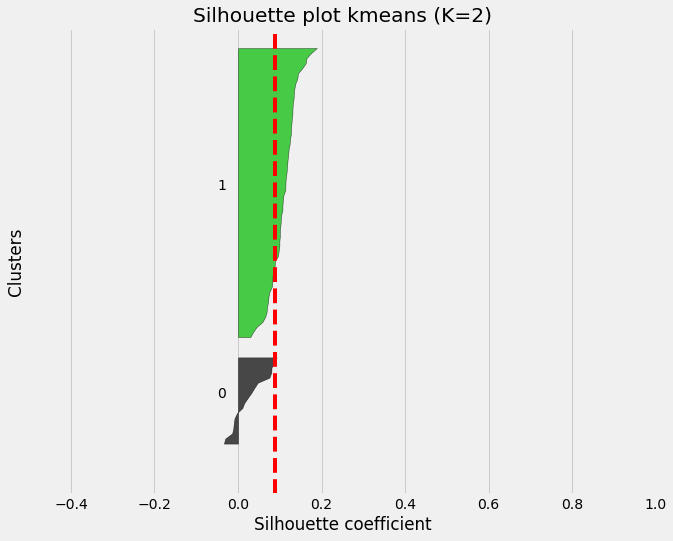

In [323]:
def drawSillouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    for i,c in enumerate(clusters):
        silhouette_values = silhouette_samples(X, labels)
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters) #np.array(["r", "g", "b", "k", "y"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    plt.show()

drawSillouette(X_PCA, kmeans_PCA.labels_, "kmeans (K=2)")

for n_clusters = 2 the silhouette score is 0.089.



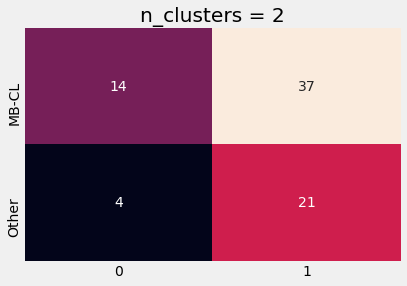

In [322]:
# Final kmeans for X_PCA
kmeans_PCA = KMeans(n_clusters=2, random_state=0)
kmeans_PCA = kmeans_X.fit(X_PCA) 

# silhouette score for X_PCA, n_clusters=2
score_PCA = silhouette_score(X_PCA, kmeans_PCA.labels_)
print('for n_clusters = 2 the silhouette score is', str(round(score_PCA, 3)) + '.\n')

# contingency matrix for X_PCA, n_clusters=2
cm_PCA=contingency_matrix(y['class'], kmeans_PCA.labels_)
sn.heatmap(cm_PCA, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
plt.title('n_clusters = 2')
plt.show()

## Comparison of Results and Discussion

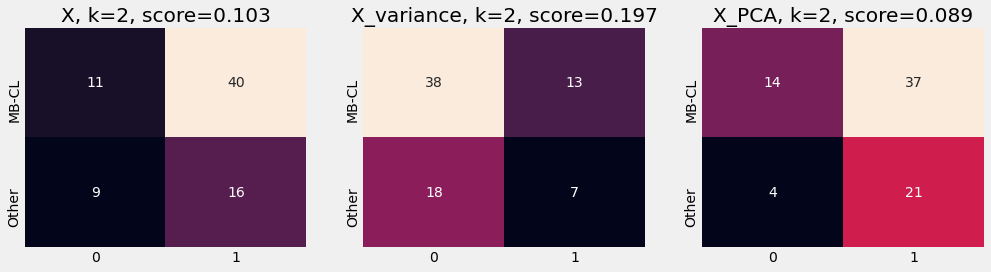

In [317]:
# defining rows and cols for the plot grid
rows=1
cols=3
fig, axes = plt.subplots(rows, cols, figsize=(14,4))

# X
sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False,
                     yticklabels=['MB-CL','Other'], ax=axes[0])
axes[0].set_title('X, k=2, score='+str(round(score_X, 3)))

# X_variance
sn.heatmap(cm_var, annot=True, cmap="rocket", cbar=False,
                     yticklabels=['MB-CL','Other'], ax=axes[1])
axes[1].set_title('X_variance, k=2, score='+str(round(score_var, 3)))

# X_PCA
sn.heatmap(cm_PCA, annot=True, cmap="rocket", cbar=False,
                     yticklabels=['MB-CL','Other'], ax=axes[2])
axes[2].set_title('X_PCA, k=2, score='+str(round(score_PCA, 3)))

fig.tight_layout()
plt.show()

> We can now compare the results obtained for X, X_variance and X_PCA. As we can see all of them show higher values of average silhouette score when k=2. This makes sense as there are 2 different labels in the dataset.
>
> For all datasets there is a cluster with a much higher number samples than the other:
> + X - cluster 0 has 20 samples, cluster 1 has 56;.
> + X_variance - cluster 0 has 56 samples, cluster 1 has 20;
> + X_PCA - cluster 0 has 18 samples, cluster 1 has 58.
>
> When it comes to the average silhouette score, the highest is for X_variance (0.197), a score that is almost double the score of X (0.103), the second highest value. X_PCA has the lowest score (0.089).
>
> All of these results are heavily influenced by the choices taken in the preprocessing steps, namely the definition of thresholds for X_variance and X_PCA. That would be an interesting experiment to conduct, to get the silhouette_scores for varying values of each threshold to try to acess its impact in the final results.
>
> However, with the parameters we used, we conclude that the clustering of X_variance using K-Means is better than the other two, as it shows the highest silhouette score and displays an acceptable separation between the classes in study.

## 4. Clustering Samples using Hierarchical Clustering

Use a **Hierarchical Clustering Algorithm (HCA)** to cluster the samples: 

* Cluster the data in **X_variance**.
    * Use **different linkage metrics**.
    * Use different values of `K`.
    * For each linkage metric and value of `K` present the clustering by specifying how many MB-CL and Other samples are in each cluster as you did before. 
    * What is the best linkage metric and the best value of `K`? Justify using the clustering results and the [Silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html).

* Cluster the data in **X_PCA**.
    * Study different linkage metrics and different values of `K` as above.

* Compare the results obtained in the two datasets above for the best linkage metric and the best `K`. 
* Discuss the results

# Different linkage metrics for k=2


linkage_metric = average



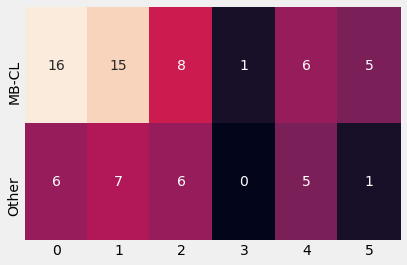


linkage_metric = ward



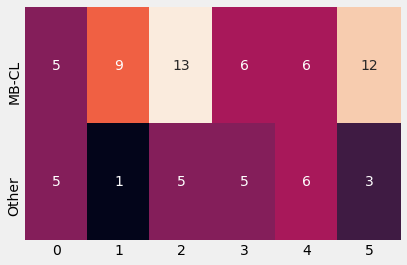


linkage_metric = complete



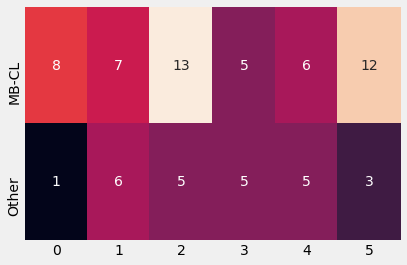


linkage_metric = single



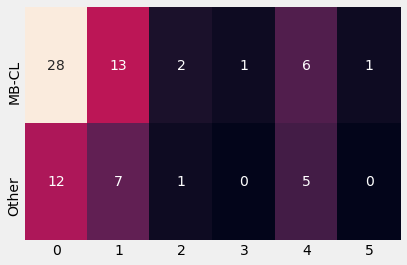

In [ ]:
from sklearn.cluster import AgglomerativeClustering

#linkage{‘ward’, ‘complete’, ‘average’, ‘single’}
#‘ward’ minimizes the variance of the clusters being merged.
#‘average’ uses the average of the distances of each observation of the two sets.
#‘complete’ or ‘maximum’ linkage uses the maximum distances between all observations of the two sets.
#‘single’ uses the minimum of the distances between all observations of the two sets.

std_X_var = StandardScaler().fit_transform(X_variance)
std_X_PCA = StandardScaler().fit_transform(X_PCA)


#hca = AgglomerativeClustering(linkage ="average", n_clusters=2)
# Grow the cluster hierarchy until K = 2 (dendogram)
#hca = hca.fit(std_X_var)
# Cluster memmberships
#hca.labels_
#cm_X_var1=contingency_matrix(y['class'], hca.labels_)
#sn.heatmap(cm_X_var1, annot=True, cmap="rocket", cbar=False, 
#           yticklabels=['MB-CL','Other'])
#plt.show()

linkage= ["average","ward","complete","single"]
for i in linkage:
  print('\nlinkage_metric = ' + str(i) + '\n')
  hca = AgglomerativeClustering(linkage =i, n_clusters=6)
  hca = hca.fit(std_X_var)
  cm_X=contingency_matrix(y['class'], hca.labels_)
  sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
  plt.show()

# Silhoutte score for various linkages


linkage_metric = average



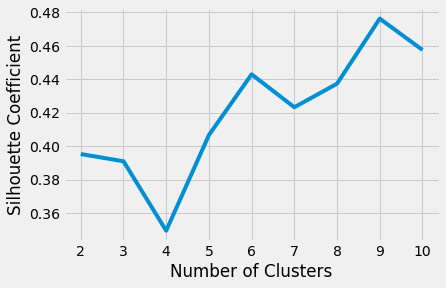


linkage_metric = ward



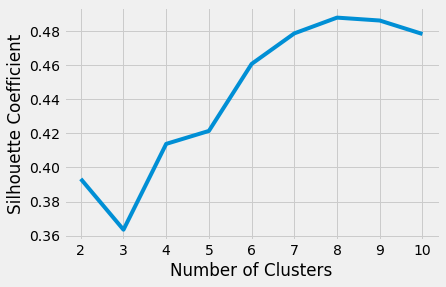


linkage_metric = complete



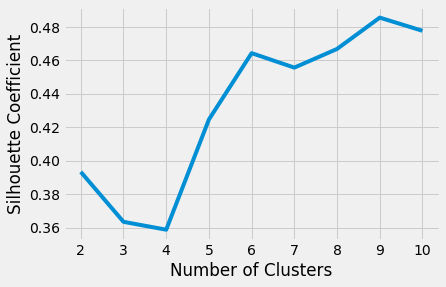


linkage_metric = single



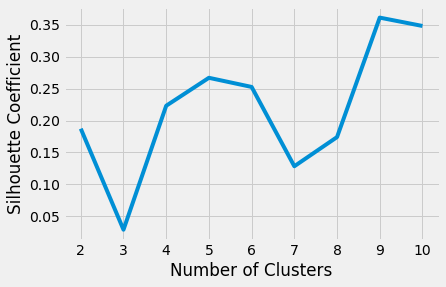

In [ ]:
linkage= ["average","ward","complete","single"]
for j in linkage:
  print('\nlinkage_metric = ' + str(j) + '\n') 
  silhouette_coefficients = []
  for i in range(2, 11):
    hca = AgglomerativeClustering(linkage =j, n_clusters=i)
    hca = hca.fit(std_X_var)
    score = silhouette_score(std_X_var, hca.labels_)
    silhouette_coefficients.append(score)

  plt.style.use("fivethirtyeight")
  plt.plot(range(2, 11), silhouette_coefficients)
  plt.xticks(range(2, 11))
  plt.xlabel("Number of Clusters")
  plt.ylabel("Silhouette Coefficient")
  plt.show()

## 5. Evaluating Clustering Results

#best k for linkage "ward"

#best k for linkage "ward"


n_cluster = 2



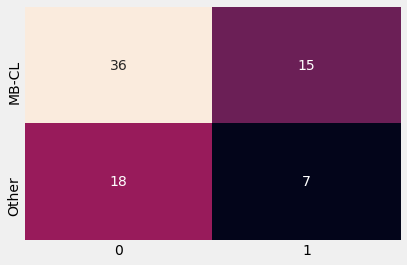


n_cluster = 3



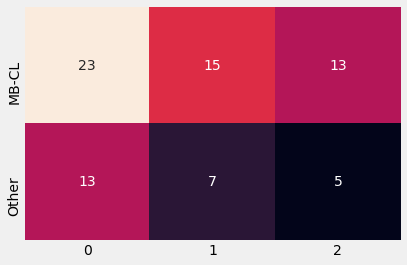


n_cluster = 4



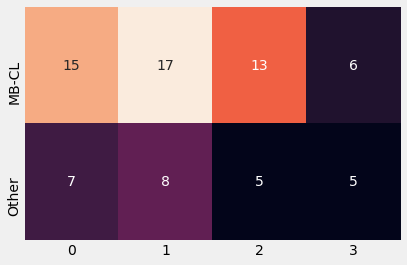


n_cluster = 5



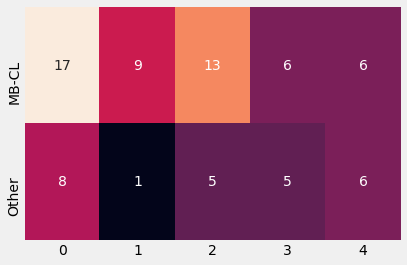


n_cluster = 6



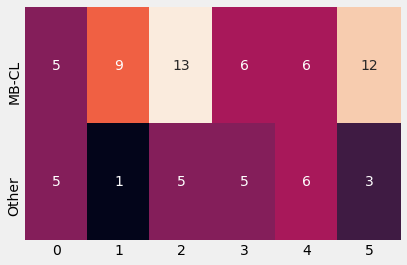


n_cluster = 7



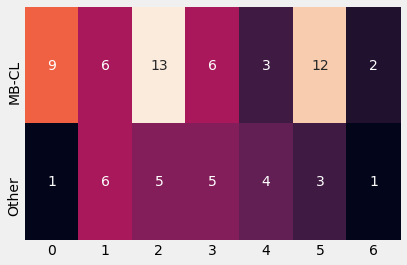


n_cluster = 8



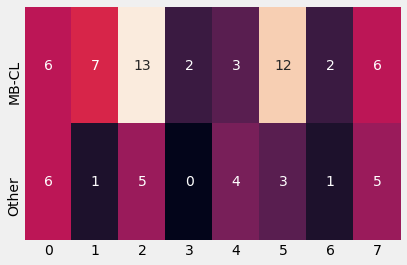


n_cluster = 9



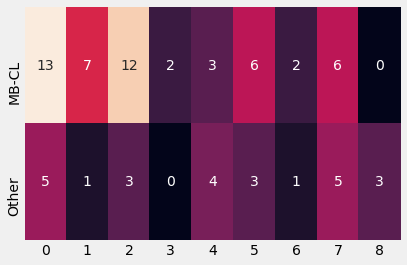


n_cluster = 10



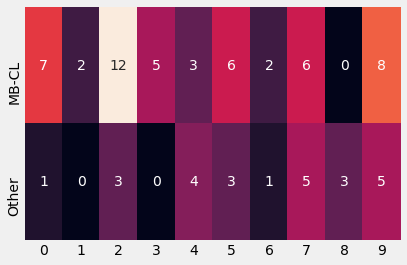

In [ ]:
for i in range(2,11):
  print('\nn_cluster = ' + str(i) + '\n')
  hca = AgglomerativeClustering(linkage ="ward", n_clusters=i)
  hca = hca.fit(std_X_var)
  cm_X=contingency_matrix(y['class'], hca.labels_)
  sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
           yticklabels=['MB-CL','Other'])
  plt.show()

In this task you should compare the best results obtained using `K`-means and HCA 
1. **Without using ground truth**
2. **Using ground truth (`Medulloblastoma Type`)**.

### 5.1. Without Using Ground Truth

**Choose one adequate measure** from those available by Sciki-learn (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the different clusterings. 

Discuss the results.

In [ ]:
print(kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)


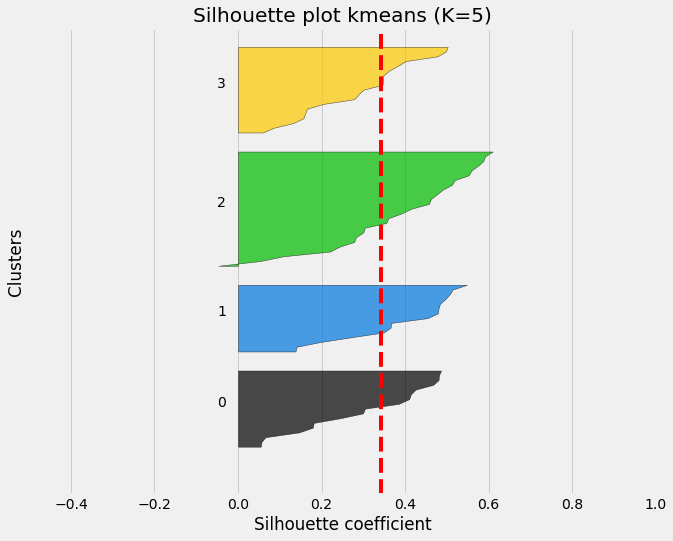

In [ ]:
from sklearn.metrics.cluster import silhouette_score, silhouette_samples
import numpy as np
import matplotlib.cm as cm
def drawSillouette(X, labels, header="" ):
    y_lower =10
    clusters=list(set(labels))
    n_clusters=len(clusters)

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.gca()
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    for i,c in enumerate(clusters):
        silhouette_values = silhouette_samples(X, labels)
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters) #np.array(["r", "g", "b", "k", "y"])[i] #
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3  # 10 for the 0 samples
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([]) 
    plt.show()

X_PCA

#drawSillouette(X, kmeans.labels_, "kmeans (K=5)")
drawSillouette(X_PCA, kmeans.labels_, "kmeans (K=5)")

EXPLAIN HERE

In [ ]:
from sklearn.metrics.cluster import calinski_harabasz_score

print("Kmeans Calinski Harabasz score is:", calinski_harabasz_score(X, kmeans.labels_))
print("   HAC Calinski Harabasz score is:", calinski_harabasz_score(X, hca.labels_))

Kmeans Calinski Harabasz score is: 4.9554021428501285
   HAC Calinski Harabasz score is: 1.904414854611475


EXPLAIN HERE

### 5.2. Using Ground Truth

**Choose one adequate measure** from those available by Sciki-learn (https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the different clusterings. 

Discuss the results.

In [ ]:
from sklearn.metrics.cluster import v_measure_score, completeness_score, homogeneity_score

yscores = y.values.ravel() #required to get values of y and transform into 2d array

print("Kmeans Homogeneity score is:", homogeneity_score(yscores, kmeans.labels_))
print("   HAC Homogeneity score is:", homogeneity_score(yscores, hca.labels_))

print("\nKmeans Completeness score is:", completeness_score(yscores, kmeans.labels_))
print("   HAC Completeness score is:", completeness_score(yscores, hca.labels_))

print("\nKmeans V-measure score is:", v_measure_score(yscores, kmeans.labels_))
print("   HAC V-measure score is:", v_measure_score(yscores, hca.labels_))

Kmeans Homogeneity score is: 0.0658198967856632
   HAC Homogeneity score is: 0.1861476762015292

Kmeans Completeness score is: 0.0304867930923782
   HAC Completeness score is: 0.05506615721599082

Kmeans V-measure score is: 0.04167182107924842
   HAC V-measure score is: 0.08499045894571189


EXPLAIN HERE

## 6. Clustering Samples using Density-based Clustering

Use DBSCAN (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) or OPTICS (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html) to cluster the samples.

Compare the results with those of K-means and HCA.

In [ ]:
# Write code in cells like this ...

## 7. Choose a Different Clustering Algorithm to Group the Samples

Choose **a clustering algorithm** besides `K`-means, HCA and DBSCAN/OPTICS to cluster the samples. 

**Groups of 3 People** must choose two different algorithms.

Justify your choice and compare the results with those of `K`-means, HCA and DBSCAN/OPTICS.

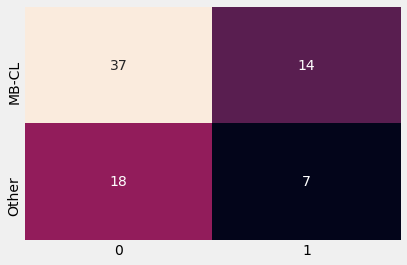

In [ ]:
from sklearn import cluster
#spectral = cluster.SpectralClustering(n_clusters=2,
#                                          eigen_solver='arpack',
#                                          affinity="nearest_neighbors")
#spectral = spectral.fit(std_X_var)
#spectral
#
#cm_X=contingencymatrix(y['class'], spectral.labels)
#sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
#         yticklabels=['MB-CL','Other'])
#plt.show()

##affinity_propagation = cluster.AffinityPropagation(damping=.9,
##                                                       preference=-50)
##affinity_propagation = affinity_propagation.fit(std_X_var)
##affinity_propagation
##cm_X=contingency_matrix(y['class'], affinitypropagation.labels)
##sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
##         yticklabels=['MB-CL','Other'])
##plt.show()

meanshift= cluster.MeanShift(bandwidth=None, seeds=None, bin_seeding=False, min_bin_freq=1, cluster_all=True, n_jobs=1)
meanshift= meanshift.fit(std_X_var)
cm_X=contingency_matrix(y['class'], meanshift.labels_)
sn.heatmap(cm_X, annot=True, cmap="rocket", cbar=False, 
         yticklabels=['MB-CL','Other'])
plt.show()

## 8. Conclusions

Draw some conclusions about this project work. Can you highlight some insights about meduloblastoma types? 

In [ ]:
# Write code in cells like this ...

Write text in cells like this...